## Learnability 

In [1]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import multiprocessing as mp
import scipy.sparse as sp

import itertools
import matplotlib.pyplot as plt
from gensim import corpora
from collections import defaultdict
from gensim.models import TfidfModel
from collections import Counter
import seaborn as sns

from tools import learnabilityHelpers as lh

## this suppresses the warnings encountered during normal use of Matthew's Corr Coeff from sklearn
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [117]:
lh.generate_kinase_labels()

Let's generate a few go_annotation datasets. 

We'll use the original annotations (post-stopwords) binarized, a single-occurence-filtered-out annotations binarized, and a single-occurence-filtered-out tfidf model.

In [113]:
go_file = '../data/goData/kinase_go_processes.csv'
go_dir = './'

# get the go annotations
go_annotations = get_go_annotations_series(go_dir+go_file)

# filter out any empty kinases
go_annotations = go_annotations[map(lambda x: len(x) > 0, [x for x in go_annotations])]

# generate binarized go_annotations
go_lab_binner, bin_go_annotations = convert_go_annotations_to_one_hot(go_annotations,
                                                   return_binarizer= True)

# create a frequency chart for every label in the go_annotations 
# this allows us to screen out labels with only one occurence (to help reduce noise)
frequency = defaultdict(int)
for doc in go_annotations:
    for word in doc:
        frequency[word] += 1
texts = [[word for word in doc if frequency[word] > 1]
         for doc in go_annotations]

# generate binarized go_annotations for the intermediate, filtered go_annotations
filter_go_annotations = pd.Series(texts)
filter_go_annotations.index = go_annotations.index
filter_go_annotations.name = go_annotations.name

# filter out any empty filter_kinases
filter_go_annotations = filter_go_annotations[map(lambda x: len(x) > 0, [x for x in filter_go_annotations])]

freq_go_lab_binner, freq_go_annotations = convert_go_annotations_to_one_hot(filter_go_annotations,
                                                   return_binarizer= True)
        
# create a corpus and dictionary (reference) objects for a tfidf model for the go_annotations
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(doc) for doc in texts]

# create a tfidf series for the go_annotations
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# we have to parse gensim's sparse format back into pd.Series format
hold = []
rej = []
for i in range(len(corpus_tfidf)):
    if(len(corpus_tfidf[i]) > 1):
        a, b = map(np.asarray, zip(*corpus_tfidf[i]))
        row = np.repeat(0, len(a))
        hold += [sp.csc_matrix((b, (row, a)), shape=(1,len(dictionary)))]
    else:
        rej += [go_annotations.index[i]]
    

tfidf_go_annotations = pd.Series([x for x in sp.vstack(hold).toarray()])
tfidf_go_annotations.index = [x for x in go_annotations.index.tolist() if x not in rej]
tfidf_go_annotations.name = go_annotations.name

# create a dictionary with our datasets
go_data_dict = {'go':bin_go_annotations,'freq':freq_go_annotations,'tfidf':tfidf_go_annotations }

Now, we need to get our cluster data and make a few DataFrames with the clusters and go_annotations attached

In [114]:
cluster_dir = '../results/'

spinglass_file = 'consensus_spinglass.txt'
spinglass_data_dict = {key:add_cluster_labels(cluster_dir+spinglass_file,
                                  val) for key, val in go_data_dict.items()}

fastgreedy_file = 'fastgreedy_clusters.txt'
fastgreedy_data_dict = {key:add_cluster_labels(cluster_dir+fastgreedy_file,
                                  val) for key, val in go_data_dict.items()}

eigen_file = 'consensus_eigenvector.txt'
eigen_data_dict = {key:add_cluster_labels(cluster_dir+eigen_file,
                                  val) for key, val in go_data_dict.items()}

labelprop_file = 'consensus_label_propagation.txt'
labelprop_dict = {key:add_cluster_labels(cluster_dir+labelprop_file,
                                  val) for key, val in go_data_dict.items()}

walktrap_file = 'consensus_walktrap.txt'
walktrap_dict = {key:add_cluster_labels(cluster_dir+walktrap_file,
                                  val) for key, val in go_data_dict.items()}

louvain_super_file = 'louvain_clusters.txt'
louvain_super_dict = {key:add_cluster_labels(cluster_dir+louvain_super_file,
                                  val) for key, val in go_data_dict.items()}

louvain_sub_file = 'louvain_small_clusters.txt'
louvain_sub_dict = {key:add_cluster_labels(cluster_dir+louvain_sub_file,
                                  val) for key, val in go_data_dict.items()}

infomap_file = 'consensus_infomap.txt'
infomap_dict = {key:add_cluster_labels(cluster_dir+infomap_file,
                                  val) for key, val in go_data_dict.items()}

edge_betweenness_file = 'edge_betweenness_community_clusters.txt'
edge_betweenness_dict = {key:add_cluster_labels(cluster_dir+edge_betweenness_file,
                                  val) for key, val in go_data_dict.items()}

method_list = ['spinglass', 'fastgreedy', 'eigen', 'labelprop', 'walktrap', 'louvain_super', 'louvain_sub', 'infomap', 'edge_between']
method_dicts = [spinglass_data_dict, fastgreedy_data_dict, eigen_data_dict, labelprop_dict, walktrap_dict, louvain_super_dict, louvain_sub_dict, infomap_dict, edge_betweenness_dict]
composite_data_dict = {x:y for x,y in zip(method_list, method_dicts)}

Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due

Now, let's import a few linear classifiers

In [4]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import ComplementNB as CNB

svm = SVC(kernel='linear', class_weight='balanced')
cnb = CNB()

classifiers = [svm, cnb]
clf_names = [str(clf.__class__).split('.')[-1][0:-2] for clf in classifiers]

And get the accuracy and MCC scores for our datasets

In [5]:
validation_kwargs = {'n_run':5, 'metrics':['accuracy', 'matthews'], 'parallel':mp.cpu_count()-1, 'test_size':0.3}
results_dict = {}

for method in composite_data_dict.keys():
    results_dict[method] = {str(clf.__class__).split('.')[-1][0:-2]:validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in composite_data_dict[method].items() for clf in classifiers}
    

In [6]:
mean_results = {}
std_results = {}

for method in method_list:
    mean_results[method] = {key:np.mean(np.vstack(map(np.array, results_dict[method][key])), axis=0) for key in results_dict[method].keys()}
    std_results[method] = {key:np.std(np.vstack(map(np.array, results_dict[method][key])), axis=0) for key in results_dict[method].keys()}
    

In [7]:
for method in method_list:
    print(method+' | '+str(mean_results[method]['SVC']))
    

spinglass | [0.21481481 0.22054486]
fastgreedy | [0.64444444 0.54826546]
eigen | [0.7037037  0.26205346]
labelprop | [0.97777778 0.82783734]
walktrap | [0.14074074 0.11631312]
louvain_super | [0.65185185 0.56035634]
louvain_sub | [0.44444444 0.41000811]
infomap | [0.41481481 0.41005765]
edge_between | [0.72592593 0.52039776]


In [8]:
for method in method_list:
    print(method+' | '+str(mean_results[method]['ComplementNB']))
    

spinglass | [0.54814815 0.49286238]
fastgreedy | [0.59259259 0.50424877]
eigen | [0.57777778 0.24501375]
labelprop | [0.78518519 0.36428771]
walktrap | [0.41481481 0.37309848]
louvain_super | [0.6       0.5031042]
louvain_sub | [0.45185185 0.40350156]
infomap | [0.55555556 0.50968568]
edge_between | [0.67407407 0.48972246]


In [10]:
mod_table = pd.read_csv('../results/clustering_modularity_results.txt', sep='\t')
mod_table

,fast_greedy,spinglass,eigen,walktrap,label,louvain,small_louvain,infomap,edge_between
0,0.350078,0.338763,0.247766,0.272734,0.017304,0.368041,0.321034,0.281936,0.170605


In [11]:
cluster_descriptions = {}
mod_scores = {}

mod_table = pd.read_csv('../results/clustering_modularity_results.txt', sep='\t')
mod_scores = {x:y for x,y in zip(method_list, mod_table.loc[0].values)}

for method in method_list:
    # grab the cluster list from one of the datatype dictionaries
    cluster_list = composite_data_dict[method]['go']['cluster']
    
    # create a counter to get the count data
    clust_counter = Counter(cluster_list)
    
    # count and number of cluster data
    cluster_counts = list(clust_counter.values())
    n_clust = len(cluster_counts)
    
    # mean and std of cluster size
    size_mean = np.round(np.mean(cluster_counts), 1)
    size_std = np.round(np.std(cluster_counts), 1)
    
    # largest and smallest cluster size
    size_max = np.max(cluster_counts) 
    
    # update size and modularity data
    cluster_descriptions[method] = {'N_clust':n_clust, 'Mean clust size':size_mean, 'Clust size std.':size_std, 'Largest clust size':size_max}
    cluster_descriptions[method].update({'Modularity':np.round(mod_scores[method],3)})
    
    # update learnability
    # clf-specific results
    #cluster_descriptions[method].update({clf_name+' accuracy':np.round(mean_results[method][clf_name],2)[0] for clf_name in clf_names})
    #cluster_descriptions[method].update({clf_name+' MCC':np.round(mean_results[method][clf_name],2)[1] for clf_name in clf_names})
    # composite results
    cluster_descriptions[method].update({'Composite Accuracy':np.round(np.mean([mean_results[method][clf_name][0] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Comp Acc std.':np.round(np.mean([std_results[method][clf_name][0] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Composite MCC':np.round(np.mean([mean_results[method][clf_name][1] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Comp MCC std.':np.round(np.mean([std_results[method][clf_name][1] for clf_name in clf_names]),2)})
    
results_df = pd.DataFrame.from_dict(cluster_descriptions, orient='index').sort_values(by='Composite MCC', ascending=False)

results_df.columns = ['No. Clusters', 'Mean size', 'sigma size', 'Largest clust',
       'Mod', 'Comp Acc', 'sigma Comp Acc', 'Comp MCC',
       'sigma Comp MCC']

display(results_df)

,No. Clusters,Mean size,sigma size,Largest clust,Mod,Comp Acc,sigma Comp Acc,Comp MCC,sigma Comp MCC
labelprop,15,31.5,110.5,445,0.273,0.88,0.0,0.60,0.0
fastgreedy,8,59.1,49.4,169,0.339,0.62,0.0,0.53,0.0
louvain_super,8,59.1,46.9,151,0.368,0.63,0.0,0.53,0.0
edge_between,16,29.6,65.2,224,0.171,0.70,0.0,0.51,0.0
infomap,57,8.3,17.3,128,0.282,0.49,0.0,0.46,0.0
louvain_sub,36,13.1,18.1,88,0.321,0.45,0.0,0.41,0.0
spinglass,59,8.0,19.8,125,0.350,0.38,0.0,0.36,0.0
eigen,11,43.0,94.7,330,0.248,0.64,0.0,0.25,0.0
walktrap,162,2.9,7.8,79,0.017,0.28,0.0,0.24,0.0


We can see that:

> 1. Leading Eigenvalues does not produce valid clusterings as while accuracy is high, MCC is relatively poor
> 2. Fast Greedy appears to have the best learnability, but we should remeber that Consensus Spinglass has many more classes
> 3. Filtering/TFIDF does not negatively impact the learnability, so we can ignore the rare labels in our analysis


## Convert pandas.DataFrame to TeX


In [12]:
tex_string = results_df.to_latex()
print(tex_string)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  No. Clusters &  Mean size &  sigma size &  Largest clust &    Mod &  Comp Acc &  sigma Comp Acc &  Comp MCC &  sigma Comp MCC \\
\midrule
labelprop     &            15 &       31.5 &       110.5 &            445 &  0.273 &      0.88 &             0.0 &      0.60 &             0.0 \\
fastgreedy    &             8 &       59.1 &        49.4 &            169 &  0.339 &      0.62 &             0.0 &      0.53 &             0.0 \\
louvain\_super &             8 &       59.1 &        46.9 &            151 &  0.368 &      0.63 &             0.0 &      0.53 &             0.0 \\
edge\_between  &            16 &       29.6 &        65.2 &            224 &  0.171 &      0.70 &             0.0 &      0.51 &             0.0 \\
infomap       &            57 &        8.3 &        17.3 &            128 &  0.282 &      0.49 &             0.0 &      0.46 &             0.0 \\
louvain\_sub   &            36 &       13.1 &        18.1 &             88 &  0.321 &  

## Generate Intra-Supercluster Analysis of Louvain Subclusters


In [13]:
louvain_combined_dict = {key:louvain_super_dict[key].drop('GO Labels', axis=1).merge(louvain_sub_dict[key], on='names', how='left', suffixes = ['_super', '_sub'])
                         for key, val in go_data_dict.items()}


In [14]:
# this is a map of the subclusters in each supercluster
super_sub_dict = louvain_combined_dict['go'].groupby('cluster_super')['cluster_sub'].agg(set)
display(super_sub_dict)

cluster_super
1                                           {8, 26, 7}
2                                   {4, 9, 10, 20, 21}
3                                             {11, 12}
4    {32, 1, 34, 36, 6, 13, 14, 15, 16, 17, 23, 24,...
5                           {35, 3, 5, 18, 25, 29, 31}
6                                                 {19}
7                                          {33, 2, 22}
8                                                 {30}
Name: cluster_sub, dtype: object

In [15]:
louvain_combined_dict.keys()

dict_keys(['go', 'freq', 'tfidf'])

In [16]:
validation_kwargs = {'n_run':5, 'metrics':['accuracy', 'matthews'], 'parallel':mp.cpu_count()-1, 'test_size':0.3}
intra_results_dict = {}

# iterate over superclusters
for sup_ in super_sub_dict.keys():
    # proceed if more than one subcluster in each supercluster
    if len(super_sub_dict[sup_]) > 1:
        for sub_ in super_sub_dict[sup_]:
            intra_results_dict[sup_] = {str(clf.__class__).split('.')[-1][0:-2]:validate_learnability(dat_df=val[val.cluster_super==sup_], clf=clf, Y_col_name='cluster_sub', **validation_kwargs) for key, val in louvain_combined_dict.items() for clf in classifiers}


In [17]:
validation_kwargs = {'n_run':5, 'metrics':['confusion'], 'parallel':max(mp.cpu_count()-1, 5), 'test_size':0.3}
conf_intra_results_dict = {}

# add linear unbalanced svc to the classifiers for visualization
classifiers_ext = {str(clf.__class__).split('.')[-1][0:-2]:clf for clf in classifiers}
unbal_svm = SVC(kernel='linear')
classifiers_ext['unbalSVM'] = unbal_svm 

# iterate over superclusters
for sup_ in super_sub_dict.keys():
    # proceed if more than one subcluster in each supercluster
    if len(super_sub_dict[sup_]) > 1:
        for sub_ in super_sub_dict[sup_]:
            conf_intra_results_dict[sup_] = {clf_key:validate_learnability(dat_df=val[val.cluster_super==sup_], clf=clf, Y_col_name='cluster_sub', **validation_kwargs) for key, val in louvain_combined_dict.items() for clf_key, clf in classifiers_ext.items()}


In [18]:
## normalize the heatmap by row
for sup_ in conf_intra_results_dict.keys():
    for learning_algo in conf_intra_results_dict[sup_].keys():
        # aggregate into average confusion matrix -- not integral do to random sampling size differences
        composite_score = np.mean(conf_intra_results_dict[sup_][learning_algo], axis=0)
        row_sums = np.sum(composite_score, axis=1)
        # normalize
        for i in range(composite_score.shape[0]):
            # add 1 for stability
            composite_score[i,:] = composite_score[i,:] / (1 if row_sums[i] == 0 else row_sums[i])
            
        conf_intra_results_dict[sup_][learning_algo] = composite_score

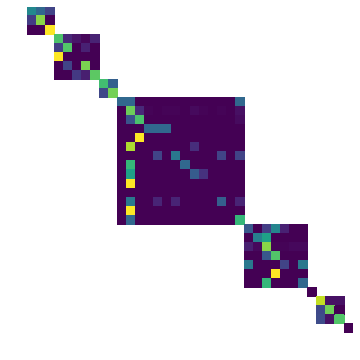

In [19]:
intra_heatmap_matrix = np.zeros((len(set(louvain_combined_dict['go'].cluster_sub)),len(set(louvain_combined_dict['go'].cluster_sub))))
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)
intra_heatmap_matrix

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['ComplementNB']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,6))
ax.axis('off')
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, ax=ax, square=True, cbar=False)

plt.show()

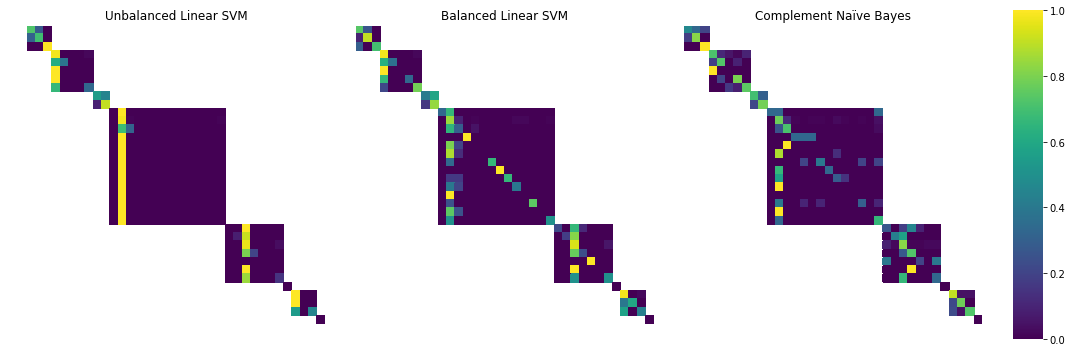

In [20]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(15,5), gridspec_kw={'width_ratios':[10,10,10,1]})
for ax in axes[:3]:
    ax.axis('off')

## put complementNB on the right    
intra_heatmap_matrix = np.zeros((len(set(louvain_combined_dict['go'].cluster_sub)),len(set(louvain_combined_dict['go'].cluster_sub))))
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['ComplementNB']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=True, ax=axes[2], cbar_ax=axes[3])


## put balanced SVC in the middle
intra_heatmap_matrix = np.zeros_like(intra_heatmap_matrix)
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['SVC']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    

sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=False, ax=axes[1])

### put unbalanced svc on the left
intra_heatmap_matrix = np.zeros_like(intra_heatmap_matrix)
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['unbalSVM']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=False, ax=axes[0])


## layout and titles
plt.tight_layout()
axes[0].set_title('Unbalanced Linear SVM')
axes[1].set_title('Balanced Linear SVM')
axes[2].set_title('Complement Naïve Bayes')

plt.savefig('intracluster_learnability_comparison.png')

plt.show()

## Generate Learnability Characterizations

In [21]:
louv_X, __, louv_y, __ = get_tts(dat=louvain_super_dict['freq'],test_size=0)

In [22]:
louv_super_characterizers = [SVC(kernel='linear', class_weight='balanced'), CNB()]
for clf in louv_super_characterizers:
    clf.fit(louv_X, louv_y)

In [34]:
def f_importances(coef, names, top=5, bot=None, plot=True, ax = None):
    ''' returns the most important top (positive) and bot (negative) features
    
    '''
    if bot is None:
        bot = top
    
    importances = coef
    
    # puts smallest first
    importances,names = zip(*sorted(zip(importances,names)))
    # smallest is still first
    most_negative_importances = importances[0:bot]
    most_negative_names = names[0:bot]
    
    most_positive_importances = importances[-top:]
    most_positive_names = names[-top:]
    
    
    if plot:
        if ax is None:
            plt.yticks(range(bot+top), most_negative_names+most_positive_names)
            plt.barh(range(bot, bot+top), most_positive_importances, align='center', color='orange')
            plt.barh(range(bot), most_negative_importances, align='center', color='blue')
            plt.show()
        else:
            ax.barh(range(bot, bot+top), most_positive_importances, align='center', color='orange')
            ax.barh(range(bot), most_negative_importances, align='center', color='blue')
            ax.set_yticks(range(bot+top))
            ax.set_yticklabels(most_negative_names+most_positive_names)
    else:
        return most_negative_names, most_negative_importances, most_positive_importances, most_positive_names
        

(n_samples, n_classes * (n_classes - 1) / 2)

In [39]:
def get_normalized_svm_coefficients_across_classes(svm):
    num_classes = len(svm.classes_)
    coeffs_orig = svm.coef_
    median_score_list = [None]*num_classes

    # get the median score for every feature across all classes
    for c in range(num_classes):
        median_score_list[c] = np.mean(get_svm_coeffs_for_cluster(svm, c), axis=0)

    medians = np.vstack(median_score_list)
    min_medians = np.min(medians, axis=0)
    max_medians = np.max(medians, axis=0)
    
    np.place(max_medians, max_medians==0.0, 1.0)

    medians = (medians-min_medians)/(max_medians-min_medians)*2-1

    return medians

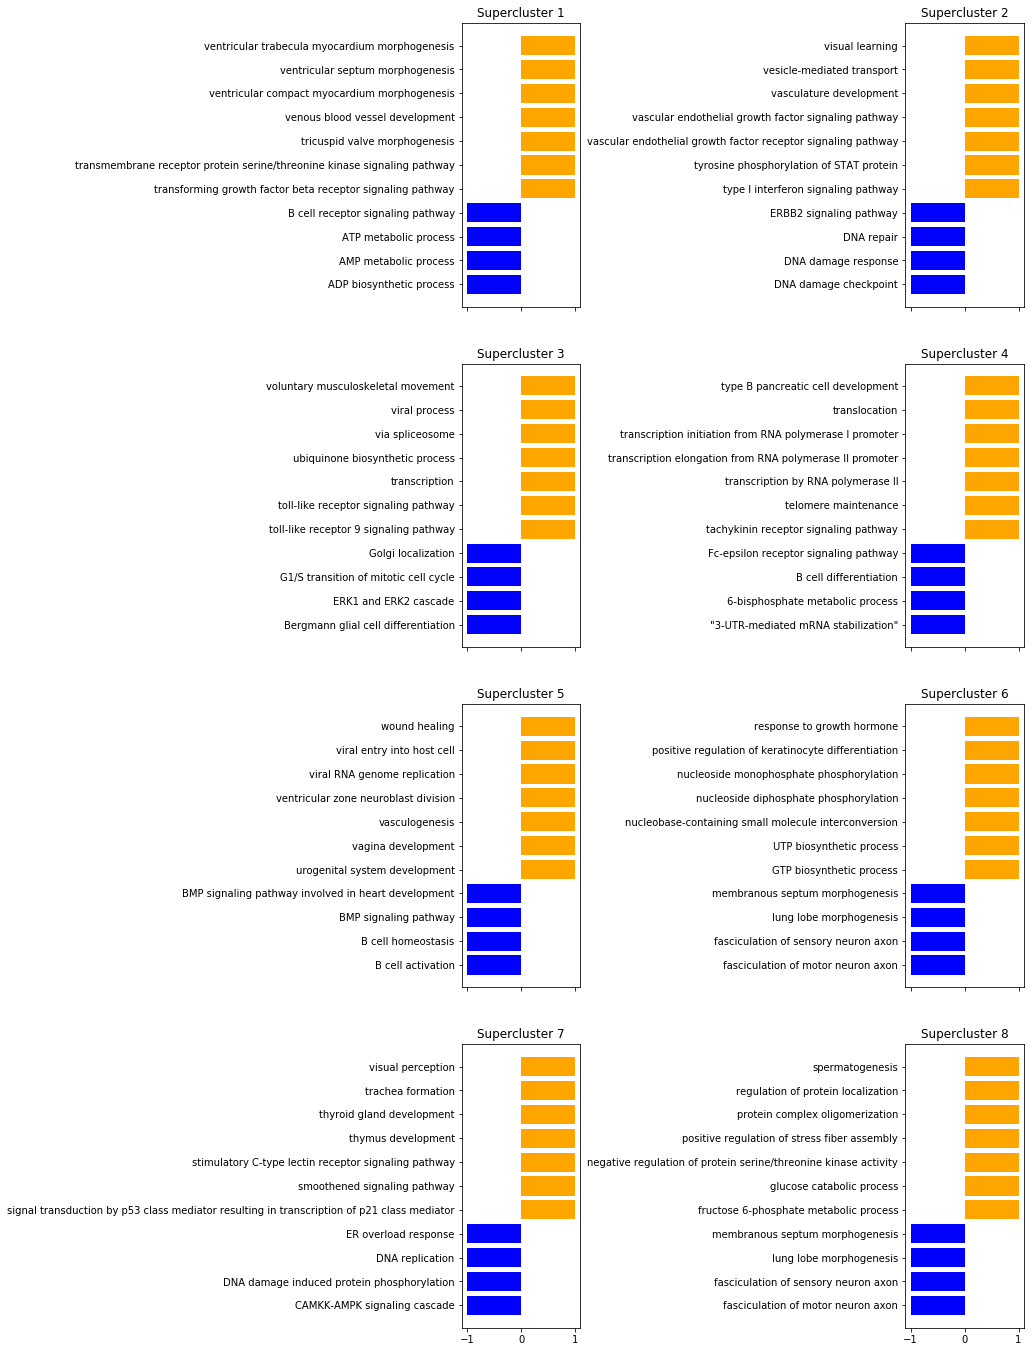

In [41]:
%matplotlib inline
fig, axes = plt.subplots(ncols=3, nrows=4, figsize= (16,24), sharex=True, gridspec_kw={'width_ratios':[1,20,20]})
plt.subplots_adjust(wspace=4.)
#plt.tight_layout()

for i in range(4):
    axes[i][0].axis('off')

for sup_ in super_sub_dict.keys():
    idx = sup_-1
    f_importances(coef=lh.get_normalized_svm_coefficients_across_classes(louv_super_characterizers[0])[sup_-1,:], names=feat, ax=axes[idx // 2][idx % 2+1], top=7, bot=4)
    axes[idx // 2][idx % 2+1].set_title('Supercluster '+str(sup_))

plt.savefig('super_char_orig.pdf')    
plt.show()
#plt.show()


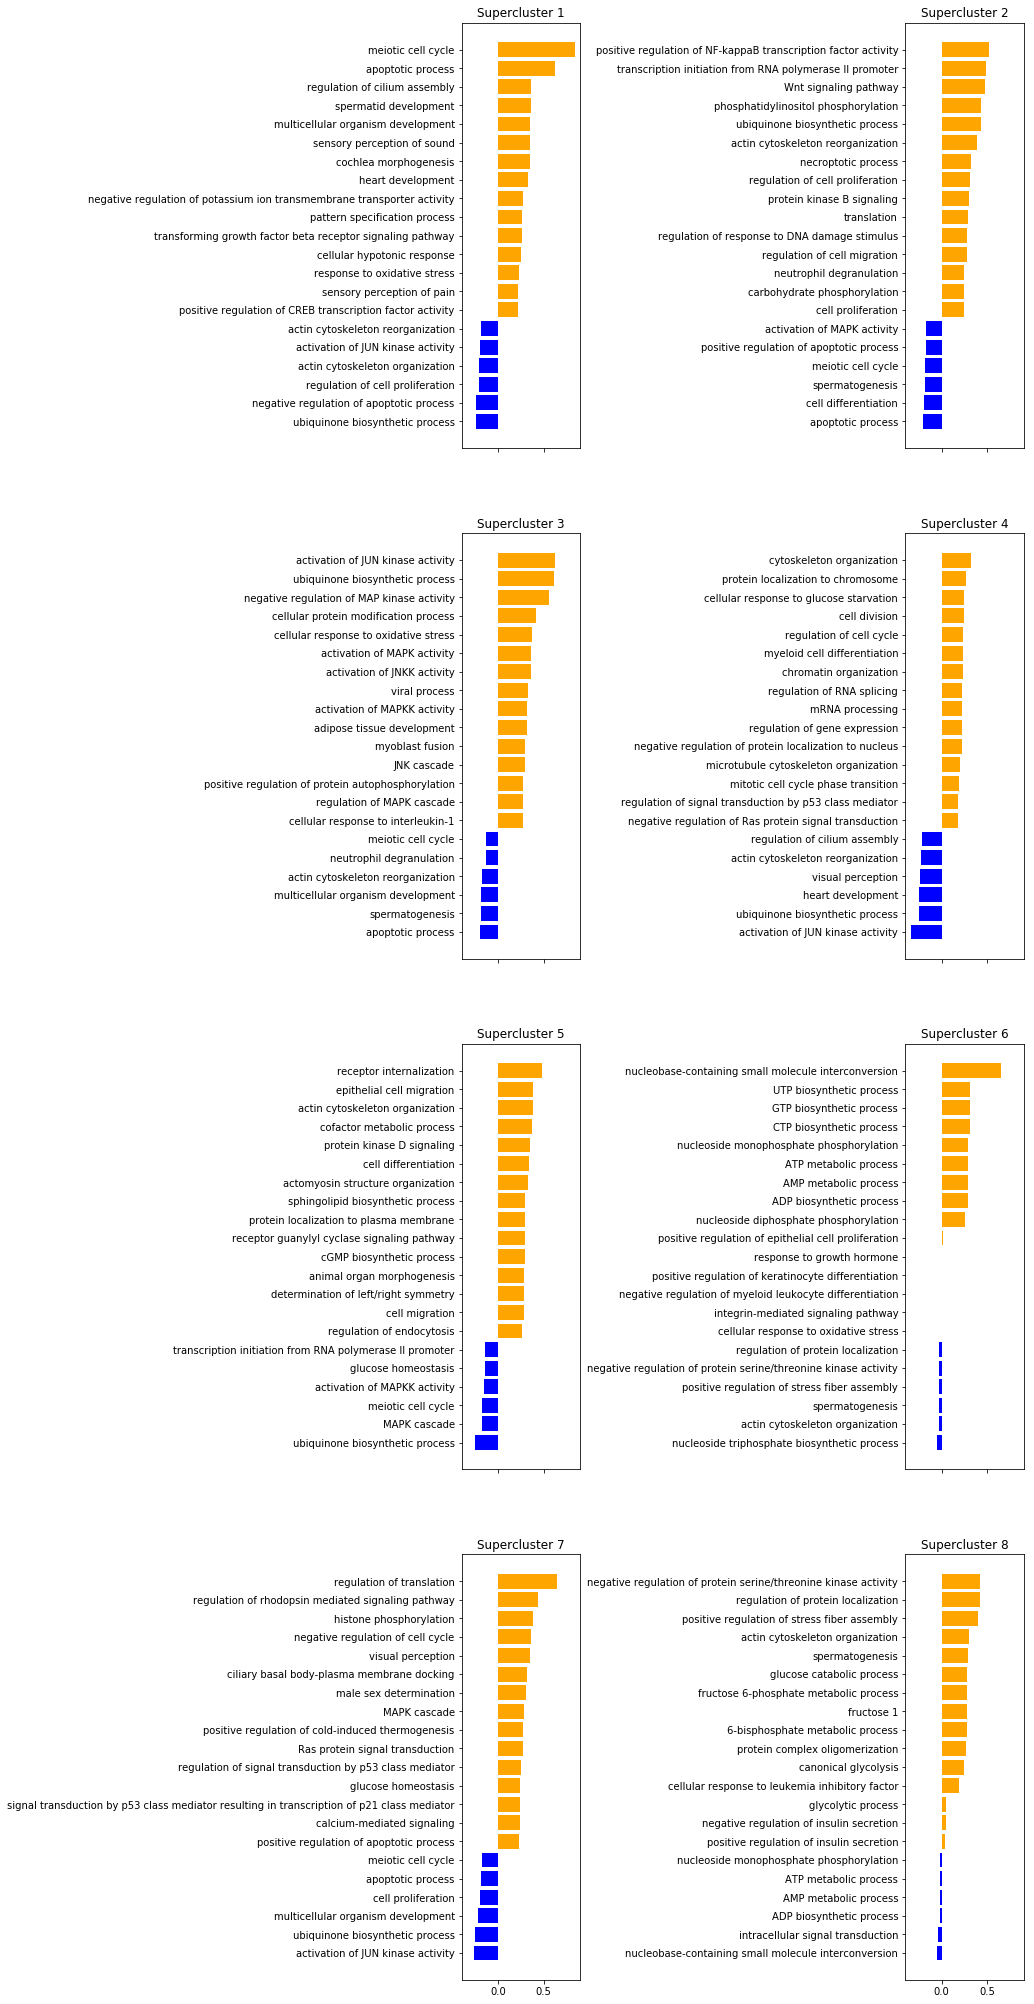

In [42]:
%matplotlib inline
fig, axes = plt.subplots(ncols=3, nrows=4, figsize= (16,36), sharex=True, gridspec_kw={'width_ratios':[1,20,20]})
plt.subplots_adjust(wspace=4.)
#plt.tight_layout()

for i in range(4):
    axes[i][0].axis('off')

for sup_ in super_sub_dict.keys():
    idx = sup_-1
    f_importances(coef=np.mean(get_svm_coeffs_for_cluster(louv_super_characterizers[0], idx), axis=0), names=feat, ax=axes[idx // 2][idx % 2+1], top=15, bot=6)
    axes[idx // 2][idx % 2+1].set_title('Supercluster '+str(sup_))

plt.savefig('super_char_orig.pdf')    
plt.show()
#plt.show()


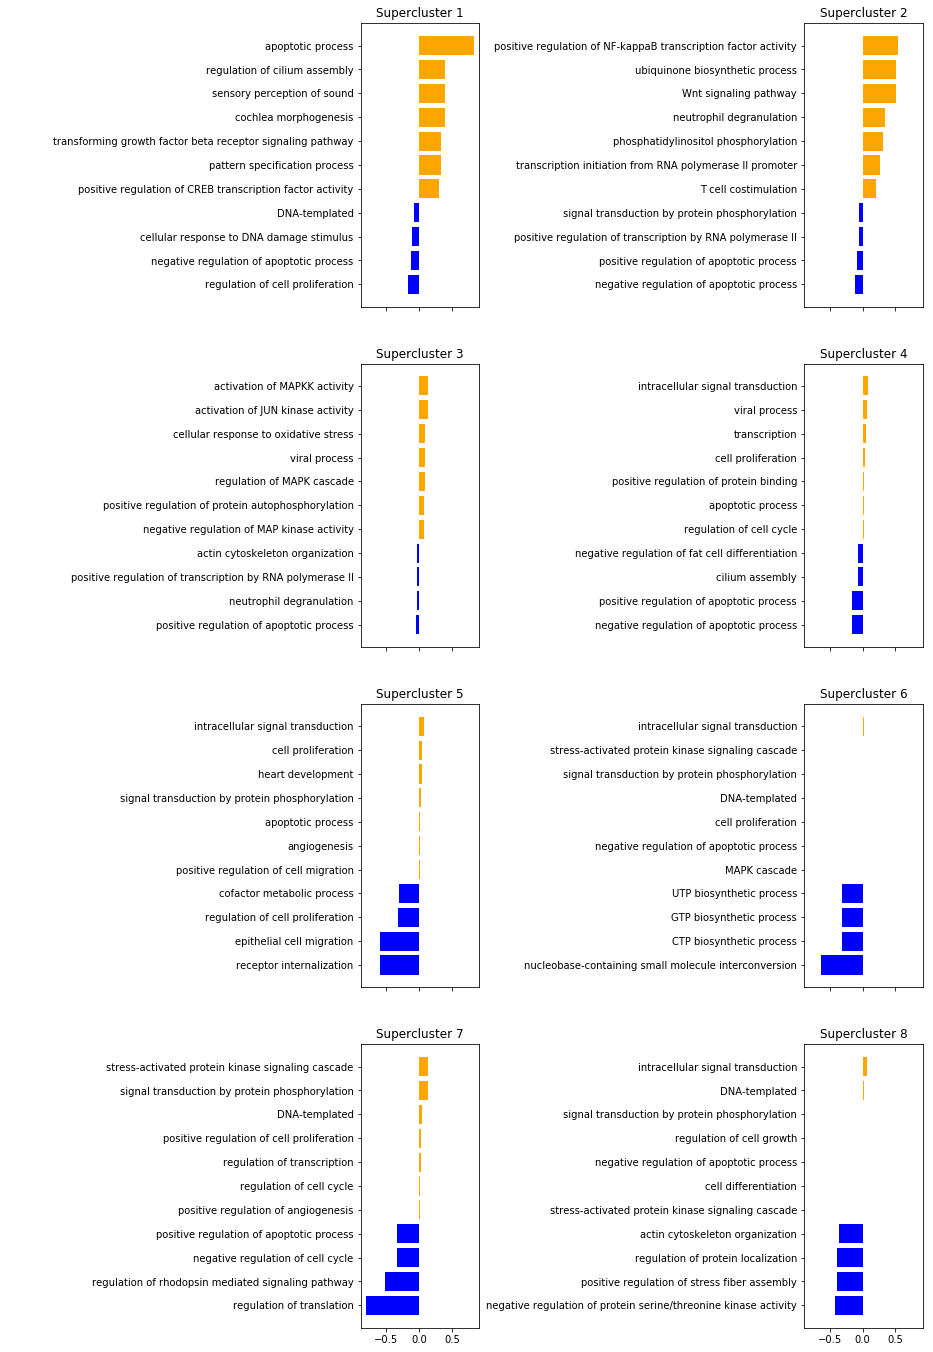

In [255]:
%matplotlib inline
fig, axes = plt.subplots(ncols=3, nrows=4, figsize= (16,24), sharex=True, gridspec_kw={'width_ratios':[1,20,20]})
plt.subplots_adjust(wspace=4.)
#plt.tight_layout()

for i in range(4):
    axes[i][0].axis('off')

for sup_ in super_sub_dict.keys():
    idx = sup_-1
    f_importances(coef=np.median(get_svm_coeffs_for_cluster(louv_super_characterizers[0], idx), axis=0), names=feat, ax=axes[idx // 2][idx % 2+1], top=7, bot=4)
    axes[idx // 2][idx % 2+1].set_title('Supercluster '+str(sup_))

plt.savefig('super_char_orig.pdf')    
plt.show()
#plt.show()


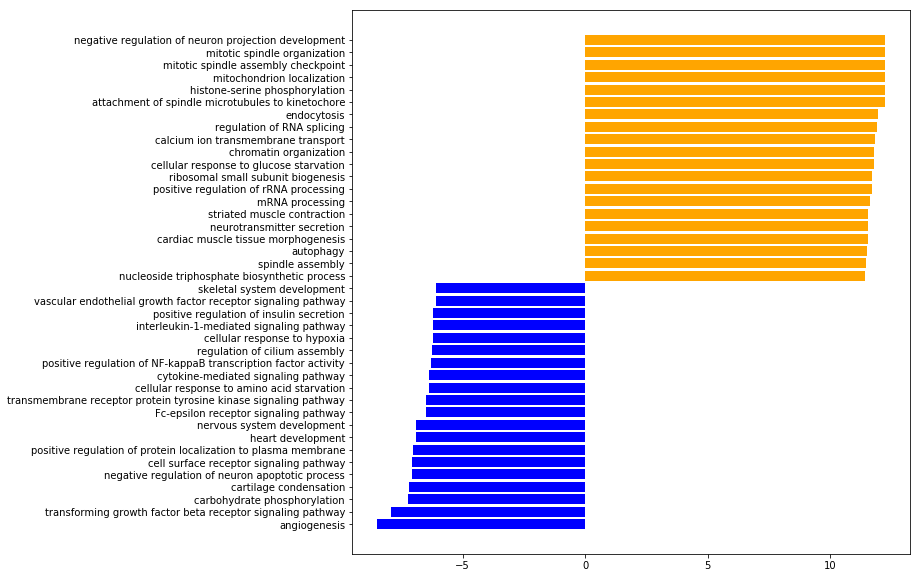

In [289]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
f_importances(coef=np.mean(coeffs, axis=0), names=feat, ax=axes, top=20, bot=20)

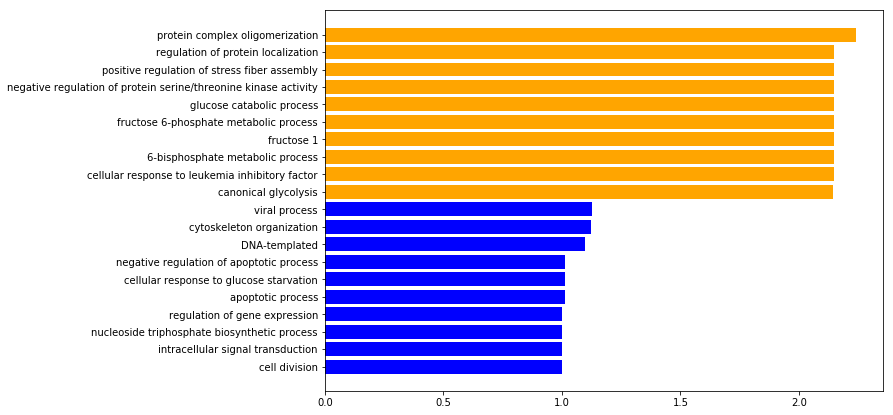

In [260]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10,7))
f_importances(coef=np.median(coeffs, axis=0), names=feat, ax=axes, top=10, bot=10)

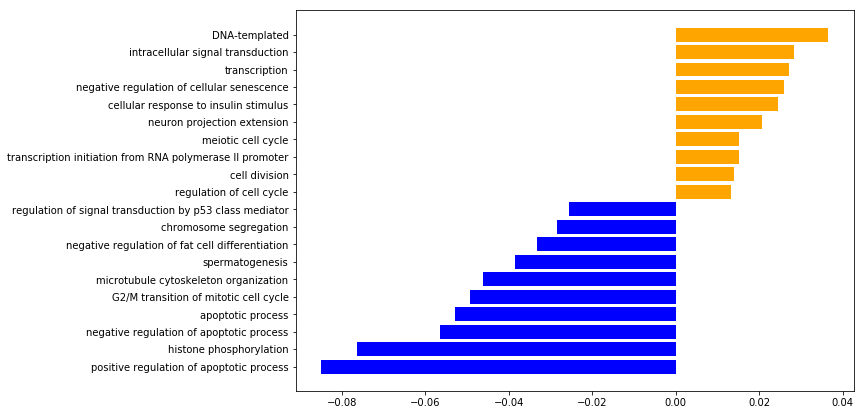

In [254]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10,7))
f_importances(coef=np.median(coeffs, axis=0), names=feat, ax=axes, top=10, bot=10)

3
[0, 1, 2, 4, 5, 6, 7]


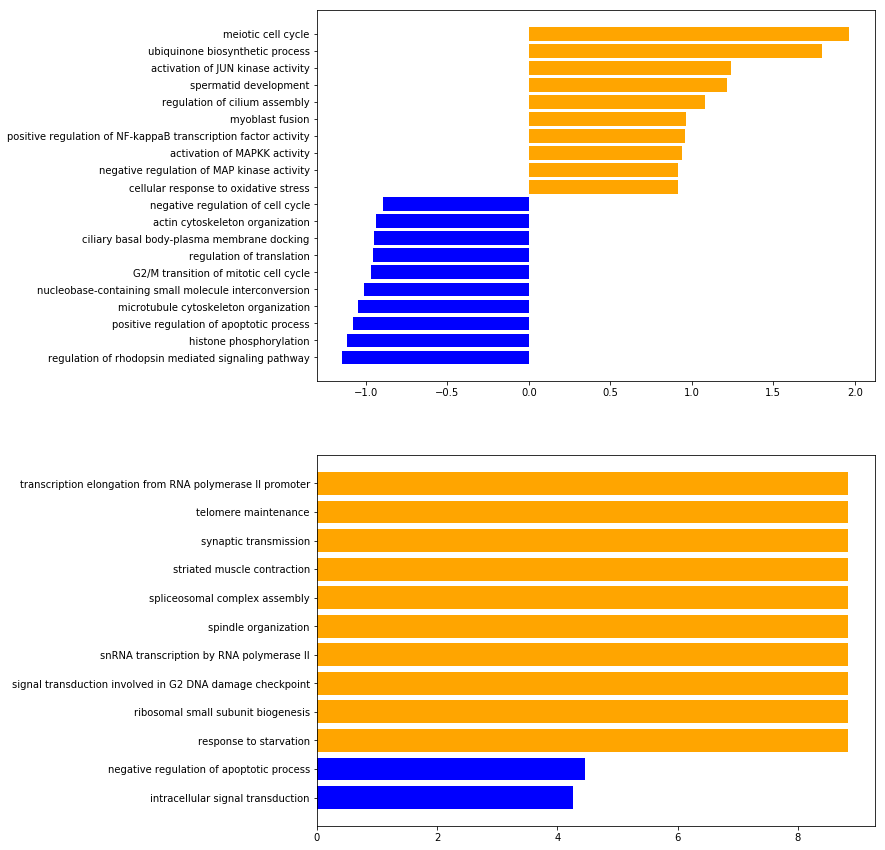

In [177]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,15))
f_importances(coef=np.sum(get_svm_coeffs_for_cluster(louv_super_characterizers[0], 3), axis=0), names=feat, ax=axes[0], top=10, bot=10)
f_importances(coef=get_cnb_coeffs_for_cluster(louv_super_characterizers[1], 3).reshape(1361,), names=feat, ax=axes[1], top=10, bot=2)

plt.show()

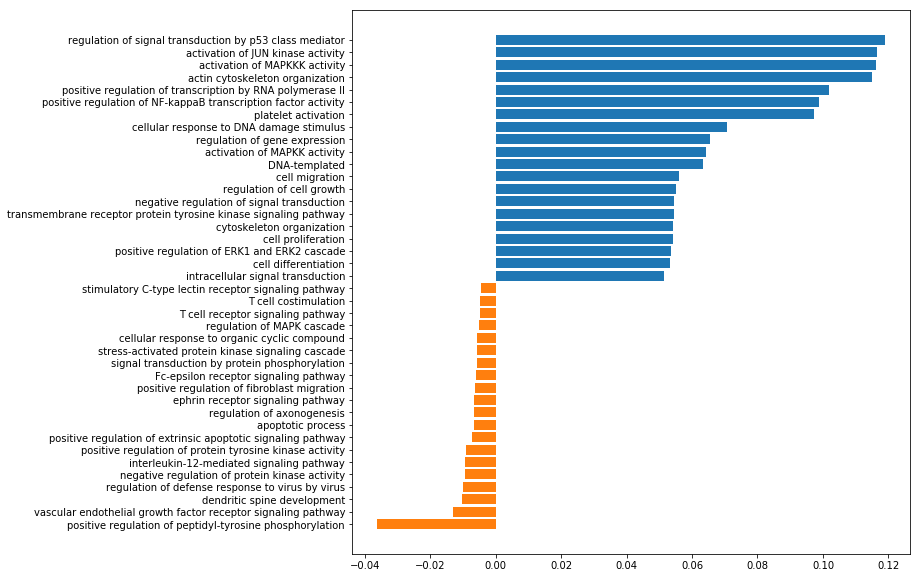

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 1), axis=0), names=feat)

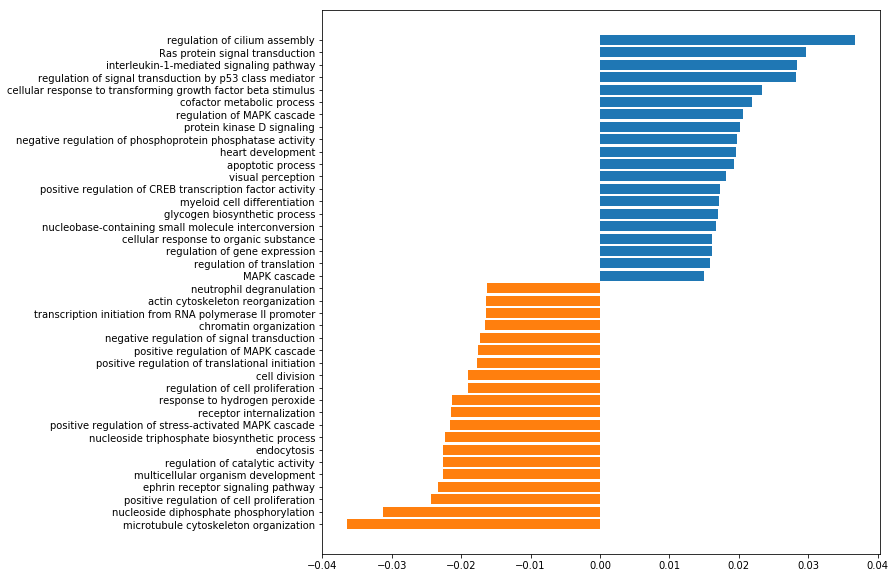

In [91]:
fig, ax = plt.subplots(figsize=(10,10))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 7), axis=0), names=feat)

In [92]:
set(filter(lambda x: 'apoptotic' in x, [term for doc in go_annotations for term in doc]))

{'B cell apoptotic process',
 'T cell apoptotic process',
 'activation of cysteine-type endopeptidase activity involved in apoptotic process',
 'activation of cysteine-type endopeptidase activity involved in apoptotic signaling pathway',
 'apoptotic cell clearance',
 'apoptotic mitochondrial changes',
 'apoptotic nuclear changes',
 'apoptotic process',
 'apoptotic signaling pathway',
 'endothelial cell apoptotic process',
 'extrinsic apoptotic signaling pathway',
 'extrinsic apoptotic signaling pathway in absence of ligand',
 'extrinsic apoptotic signaling pathway via death domain receptors',
 'fibroblast growth factor receptor apoptotic signaling pathway',
 'hepatocyte apoptotic process',
 'intrinsic apoptotic signaling pathway',
 'intrinsic apoptotic signaling pathway by p53 class mediator',
 'intrinsic apoptotic signaling pathway in response to DNA damage',
 'intrinsic apoptotic signaling pathway in response to DNA damage by p53 class mediator',
 'intrinsic apoptotic signaling pathw

In [93]:
location = np.where(freq_go_lab_binner.transform(['apoptotic process']))[1][0]
print(location)

95


### Understudied Test

In [45]:
from scipy.stats import hypergeom
understudied = pd.read_csv('../data/dark_kinases.csv').symbol.tolist()

def test_understudied(clust, understudied, M):
    N = len(clust)
    
    rv = hypergeom(M, len(understudied), N)
    
    k = sum(map(lambda x: x in understudied, clust))
    
    return rv.pmf(k)

In [46]:
understudied_p_vals = []
louv_cluster_df = copy(louvain_combined_dict['go'].drop('GO Labels', axis=1))
louv_cluster_df.head()

,cluster_super,cluster_sub
PAK1,5,3
ERBB2,5,18
MST1R,5,18
YES1,5,18
TYRO3,5,18


In [47]:
louv_cluster_df['understudied'] = pd.Series(louv_cluster_df.index.to_list()).apply(lambda x: x in understudied).to_list()

In [51]:
understudied_super_p_vals = {}
for i in sorted(louv_cluster_df.cluster_super.unique()):
    understudied_super_p_vals[i]=test_understudied(louv_cluster_df[louv_cluster_df['cluster_super']==i].index.to_list(), understudied, M=len(louv_cluster_df))
    
understudied_sub_p_vals = {}
for i in sorted(louv_cluster_df.cluster_sub.unique()):
    understudied_sub_p_vals[i]=test_understudied(louv_cluster_df[louv_cluster_df['cluster_sub']==i].index.to_list(), understudied, M=len(louv_cluster_df))

In [56]:
understudied_super_clusts = []
understudied_sub_clusts = []

for clust, p_val in understudied_super_p_vals.items():
    if(p_val < 0.05):
        understudied_super_clusts += [clust]
        
for clust, p_val in understudied_sub_p_vals.items():
    if(p_val < 0.05):
        understudied_sub_clusts += [clust]
        
print(understudied_super_clusts)
print(list(zip(understudied_sub_clusts, [sub_super_dict[x] for x in understudied_sub_clusts])))

[2, 3, 4, 5, 7]
[(2, 7), (4, 2), (5, 5), (6, 4), (8, 1), (12, 3), (18, 5), (35, 5)]


In [57]:
super_under_map = (louv_cluster_df.groupby('cluster_super')['understudied'].agg(sum)/louv_cluster_df.groupby('cluster_super')['understudied'].agg(len)).to_dict()
sub_under_map = (louv_cluster_df.groupby('cluster_sub')['understudied'].agg(sum)/louv_cluster_df.groupby('cluster_sub')['understudied'].agg(len)).to_dict()
louv_cluster_df['super_prop_under'] = louv_cluster_df.cluster_super.apply(super_under_map.get)
louv_cluster_df['super_under_pval'] = louv_cluster_df.cluster_super.apply(understudied_super_p_vals.get)
louv_cluster_df['sub_prop_under'] = louv_cluster_df.cluster_sub.apply(sub_under_map.get)
louv_cluster_df['sub_under_pval'] = louv_cluster_df.cluster_sub.apply(understudied_sub_p_vals.get)

louv_cluster_df.head()

,cluster_super,cluster_sub,understudied,super_prop_under,super_under_pval,sub_prop_under,sub_under_pval
PAK1,5,3,False,0.088235,5.041842e-11,0.25,2.685250e-01
ERBB2,5,18,False,0.088235,5.041842e-11,0.05,1.413782e-08
MST1R,5,18,False,0.088235,5.041842e-11,0.05,1.413782e-08
YES1,5,18,False,0.088235,5.041842e-11,0.05,1.413782e-08
TYRO3,5,18,False,0.088235,5.041842e-11,0.05,1.413782e-08


In [58]:
agg_dict = {'understudied':len}
agg_dict.update({x:np.mean for x in ['super_prop_under','super_under_pval','sub_prop_under','sub_under_pval']})

understudied_table = louv_cluster_df.groupby(['cluster_super', 'cluster_sub']).agg(agg_dict)
understudied_table.columns = ['Size', 'Super % Under', 'Super Prop. p-val', 'Sub % Under', 'Sub Prop. p-val']

understudied_table['Super % Under'] = understudied_table['Super % Under'].apply(lambda x: np.round(x*100,1))
understudied_table['Sub % Under'] = understudied_table['Sub % Under'].apply(lambda x: np.round(x*100,1))

for col in understudied_table.columns:
    understudied_table[col] = understudied_table[col].apply(lambda x: np.round(x, 4))
understudied_table


Size  Super % Under  Super Prop. p-val  \
cluster_super cluster_sub                                           
1             7              12           22.2             0.0719   
              8               8           22.2             0.0719   
              26              7           22.2             0.0719   
2             4              41           12.0             0.0000   
              9              18           12.0             0.0000   
              10              2           12.0             0.0000   
              20              5           12.0             0.0000   
              21              9           12.0             0.0000   
3             11             23           15.5             0.0005   
              12             35           15.5             0.0005   
4             1               2           41.1             0.0074   
              6              88           41.1             0.0074   
              13             27           41.1             0.0074   
              14              2           41.1             0.0074   
              15              2           41.1             0.0074   
              16              4           41.1             0.0074   
              17              4           41.1             0.0074   
              23              2           41.1             0.0074   
              24              5           41.1             0.0074   
              27              4           41.1             0.0074   
              28              2           41.1             0.0074   
              32              5           41.1             0.0074   
              34              2           41.1             0.0074   
              36              2           41.1             0.0074   
5             3               8            8.8             0.0000   
              5               8            8.8             0.0000   
              18             60            8.8             0.0000   
              25              8            8.8             0.0000   
              29              2            8.8             0.0000   
              31              2            8.8             0.0000   
              35             14            8.8             0.0000   
6             19              5            0.0             0.1235   
7             2              30           23.5             0.0311   
              22              4           23.5             0.0311   
              33             17           23.5             0.0311   
8             30              4           25.0             0.3920   

                           Sub % Under  Sub Prop. p-val  
cluster_super cluster_sub                                
1             7                   33.3           0.2412  
              8                    0.0           0.0347  
              26                  28.6           0.3057  
2             4                    2.4           0.0000  
              9                   16.7           0.0606  
              10                   0.0           0.4346  
              20                   0.0           0.1235  
              21                  55.6           0.1084  
3             11                  26.1           0.1337  
              12                   8.6           0.0003  
4             1                  100.0           0.1154  
              6                   46.6           0.0025  
              13                  25.9           0.1145  
              14                   0.0           0.4346  
              15                 100.0           0.1154  
              16                  25.0           0.3920  
              17                  25.0           0.3920  
              23                   0.0           0.4346  
              24                  20.0           0.3228  
              27                  50.0           0.3035  
              28                  50.0           0.4500  
              32                   0.0           0.1235  
            

In [60]:
understudied_filled_table = copy(understudied_table)
to_keep = np.zeros_like(understudied_filled_table.index.get_level_values(0))

understudied_filled_table = understudied_filled_table[['Super % Under', 'Super Prop. p-val', 'Size', 'Sub % Under', 'Sub Prop. p-val']]

for sup_ in understudied_filled_table.index.get_level_values(0):
    local_tab = understudied_filled_table.loc[sup_]
    first_sub = local_tab.index.to_list()[0]
    to_keep = np.logical_or(to_keep, [x == first_sub for x in understudied_filled_table.index.get_level_values(1).to_list()])
    
understudied_filled_table['Super % Under'][~to_keep] = ''
understudied_filled_table['Super Prop. p-val'][~to_keep] = ''

display(understudied_filled_table.head())
print(understudied_filled_table.to_latex())

Super % Under Super Prop. p-val  Size  Sub % Under  \
cluster_super cluster_sub                                                      
1             7                    22.2            0.0719    12         33.3   
              8                                               8          0.0   
              26                                              7         28.6   
2             4                      12                 0    41          2.4   
              9                                              18         16.7   

                           Sub Prop. p-val  
cluster_super cluster_sub                   
1             7                     0.2412  
              8                     0.0347  
              26                    0.3057  
2             4                     0.0000  
              9                     0.0606

\begin{tabular}{llllrrr}
\toprule
  &    & Super \% Under & Super Prop. p-val &  Size &  Sub \% Under &  Sub Prop. p-val \\
cluster\_super & cluster\_sub &               &                   &       &              &                  \\
\midrule
1 & 7  &          22.2 &            0.0719 &    12 &         33.3 &           0.2412 \\
  & 8  &               &                   &     8 &          0.0 &           0.0347 \\
  & 26 &               &                   &     7 &         28.6 &           0.3057 \\
2 & 4  &            12 &                 0 &    41 &          2.4 &           0.0000 \\
  & 9  &               &                   &    18 &         16.7 &           0.0606 \\
  & 10 &               &                   &     2 &          0.0 &           0.4346 \\
  & 20 &               &                   &     5 &          0.0 &           0.1235 \\
  & 21 &               &                   &     9 &         55.6 &           0.1084 \\
3 & 11 &          15.5 &            0.0005 &    23 &

### Generate GO Slim whitelist

In [170]:
paf = pd.read_csv('../data/goData/PAF.txt', sep='\t')
display(paf.shape)
paf.head()


(6045, 17)

,PRO_ID,Object_term,Object_syny,Modifier,Relation,Ontology_ID,Ontology_term,Relative_to,Interaction_with,Evidence_source,Evidence_code,Taxon,Inferred_from,DB_ID,Date,Assigned_by,Comment
0,PR:000000002,E3 ubiquitin ligase SFC complex Skp1 subunit,NaN,NaN,has_part,Pfam:PF01466,"Skp1 family, dimerisation domain",NaN,NaN,PIRSF:PIRSF028729,ISS,NaN,PIRSF:PIRSF028729,PIRSF:PIRSF028729,20080301,PRO:CNA,NaN
1,PR:000000002,E3 ubiquitin ligase SFC complex Skp1 subunit,NaN,NaN,has_part,Pfam:PF03931,"Skp1 family, tetramerisation domain",NaN,NaN,PIRSF:PIRSF028729,ISS,NaN,PIRSF:PIRSF028729,PIRSF:PIRSF028729,20080301,PRO:CNA,NaN
2,PR:000000002,E3 ubiquitin ligase SFC complex Skp1 subunit,NaN,NaN,part_of,GO:0019005,SCF ubiquitin ligase complex,NaN,NaN,PIRSF:PIRSF028729,ISS,NaN,PIRSF:PIRSF028729,PIRSF:PIRSF028729,20080301,PRO:CNA,NaN
3,PR:000000002,E3 ubiquitin ligase SFC complex Skp1 subunit,NaN,NaN,participates_in,GO:0006511,ubiquitin-dependent protein catabolic process,NaN,NaN,PIRSF:PIRSF028729,ISS,NaN,PIRSF:PIRSF028729,PIRSF:PIRSF028729,20080301,PRO:CNA,NaN
4,PR:000000003,HLH DNA-binding protein inhibitor,bHLH clade D|bHLH class V|DNA-binding protein ...,NaN,has_function,GO:0003700,DNA-binding transcription factor activity,NaN,NaN,PIRSF:PIRSF005808,ISS,NaN,PIRSF:PIRSF005808,PIRSF:PIRSF005808,20150820,PRO:CNA,NaN


In [183]:
paf[paf['Ontology_ID'].apply(lambda x: 'GO:' in x)][['Ontology_ID', 'Ontology_term']].set_index('Ontology_ID').to_csv('../data/goData/go_subset.csv', sep='\t', header=False)

In [82]:
# parse obo format
output_terms = []
with open('../data/goData/goslim_generic.obo', 'r') as f:
    next_lin = f.readline()
    while next_lin != '':
        if next_lin== '[Term]\n':
            current_term = []
            
            next_lin = f.readline()
            while next_lin != '\n':
                current_term += [next_lin.replace('\n','')]
                next_lin = f.readline()
            
            output_terms += [current_term]
        
        next_lin = f.readline()

# filter to biological processes        
output_terms = [term for term in output_terms if 'namespace: biological_process' in term]

# filter out subsets
for i, term in enumerate(output_terms):
    output_terms[i] = list(filter(lambda x: 'subset' not in x, term))
    
print(len([go_id for term in output_terms for go_id in term if 'id:' in go_id]))
print(len({go_id:None for term in output_terms for go_id in term if 'id:' in go_id}))
go_subset = {}
for term in output_terms:
    ids_present = list(filter(lambda x: 'id:' in x, term))
    name = list(filter(lambda x: 'name:' in x, term))[0]
    for go_id in ids_present:
        go_subset[go_id.split(' ')[1]] = name
        
pd.DataFrame.from_dict(go_subset, orient='index').to_csv('../data/goData/go_subset.csv', sep='\t', header=False)

In [184]:
# make go subset data
lh.generate_kinase_labels(use_go_subset=True, out_path='../data/goData/kinase_go_slim_processes.csv')

In [185]:
def get_go_data_dict(go_file='../data/goData/kinase_go_processes.csv', go_dir='./'):
    # get the go annotations
    go_annotations = get_go_annotations_series(go_dir+go_file)

    # filter out any empty kinases
    go_annotations = go_annotations[map(lambda x: len(x) > 0, [x for x in go_annotations])]

    # generate binarized go_annotations
    go_lab_binner, bin_go_annotations = convert_go_annotations_to_one_hot(go_annotations,
                                                       return_binarizer= True)

    # create a frequency chart for every label in the go_annotations 
    # this allows us to screen out labels with only one occurence (to help reduce noise)
    frequency = defaultdict(int)
    for doc in go_annotations:
        for word in doc:
            frequency[word] += 1
    texts = [[word for word in doc if frequency[word] > 1]
             for doc in go_annotations]

    # generate binarized go_annotations for the intermediate, filtered go_annotations
    filter_go_annotations = pd.Series(texts)
    filter_go_annotations.index = go_annotations.index
    filter_go_annotations.name = go_annotations.name

    # filter out any empty filter_kinases
    filter_go_annotations = filter_go_annotations[map(lambda x: len(x) > 0, [x for x in filter_go_annotations])]

    freq_go_lab_binner, freq_go_annotations = convert_go_annotations_to_one_hot(filter_go_annotations,
                                                       return_binarizer= True)

    # create a corpus and dictionary (reference) objects for a tfidf model for the go_annotations
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(doc) for doc in texts]

    # create a tfidf series for the go_annotations
    tfidf = TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    # we have to parse gensim's sparse format back into pd.Series format
    hold = []
    rej = []
    for i in range(len(corpus_tfidf)):
        if(len(corpus_tfidf[i]) > 1):
            a, b = map(np.asarray, zip(*corpus_tfidf[i]))
            row = np.repeat(0, len(a))
            hold += [sp.csc_matrix((b, (row, a)), shape=(1,len(dictionary)))]
        else:
            rej += [go_annotations.index[i]]


    tfidf_go_annotations = pd.Series([x for x in sp.vstack(hold).toarray()])
    tfidf_go_annotations.index = [x for x in go_annotations.index.tolist() if x not in rej]
    tfidf_go_annotations.name = go_annotations.name

    # create a dictionary with our datasets
    go_data_dict = {'go':bin_go_annotations,'freq':freq_go_annotations,'tfidf':tfidf_go_annotations}
    transform_dict = {'freq':freq_go_lab_binner}
    
    return go_data_dict, transform_dict

In [218]:
go_slim_data_dict, go_slim_transform_dict = lh.get_go_data_dict(go_file='../data/goData/kinase_go_slim_processes.csv')

In [193]:
go_slim_data_dict['freq'].iloc[1].shape

(246,)

In [219]:
missing = list(set(go_slim_data_dict['go'].index) - set(go_slim_data_dict['freq'].index))

missing_df = pd.DataFrame([[[0]*len(go_slim_data_dict['freq'].iloc[0])]], index=missing)
go_slim_data_dict['freq'] = go_slim_data_dict['freq'].append(missing_df)
#missing_df

In [221]:
slim_test = pd.DataFrame(go_slim_data_dict['freq'])
slim_test.columns = ['GO Labels']
slim_test['cluster'] = louv_cluster_df.cluster_super.to_list()
slim_test.head()

,GO Labels,cluster
PAK1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",5
AKT2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
NEK7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
BMPR1A,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",5
TTBK1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5


In [222]:
louv_X, __, louv_y, __ = get_tts(dat=slim_test,test_size=0)
louv_slim_super_characterizers = [SVC(kernel='linear', class_weight='balanced'), CNB()]
for clf in louv_slim_super_characterizers:
    clf.fit(louv_X, louv_y)
    
slim_feat = list(go_slim_transform_dict['freq'].classes_)#.to_list()
slim_feat

['BMP signaling pathway',
 'DNA damage induced protein phosphorylation',
 'DNA repair',
 'DNA-templated',
 'ERK1 and ERK2 cascade',
 'Fc-epsilon receptor signaling pathway',
 'MAPK cascade',
 'Mullerian duct regression',
 'MyD88-dependent toll-like receptor signaling pathway',
 'MyD88-independent toll-like receptor signaling pathway',
 'Rho protein signal transduction',
 'T cell receptor signaling pathway',
 'Wnt signaling pathway',
 'actin cytoskeleton organization',
 'actin cytoskeleton reorganization',
 'activation of GTPase activity',
 'activation of JUN kinase activity',
 'activin receptor signaling pathway',
 'adherens junction assembly',
 'angiogenesis',
 'animal organ morphogenesis',
 'anterior/posterior pattern specification',
 'apoptotic mitochondrial changes',
 'apoptotic process',
 'apoptotic signaling pathway',
 'attachment of spindle microtubules to kinetochore',
 'axon guidance',
 'blood coagulation',
 'branching involved in blood vessel morphogenesis',
 'branching morph

In [224]:
louv_slim_super_characterizers[0].score(louv_X, louv_y)

0.6173361522198731

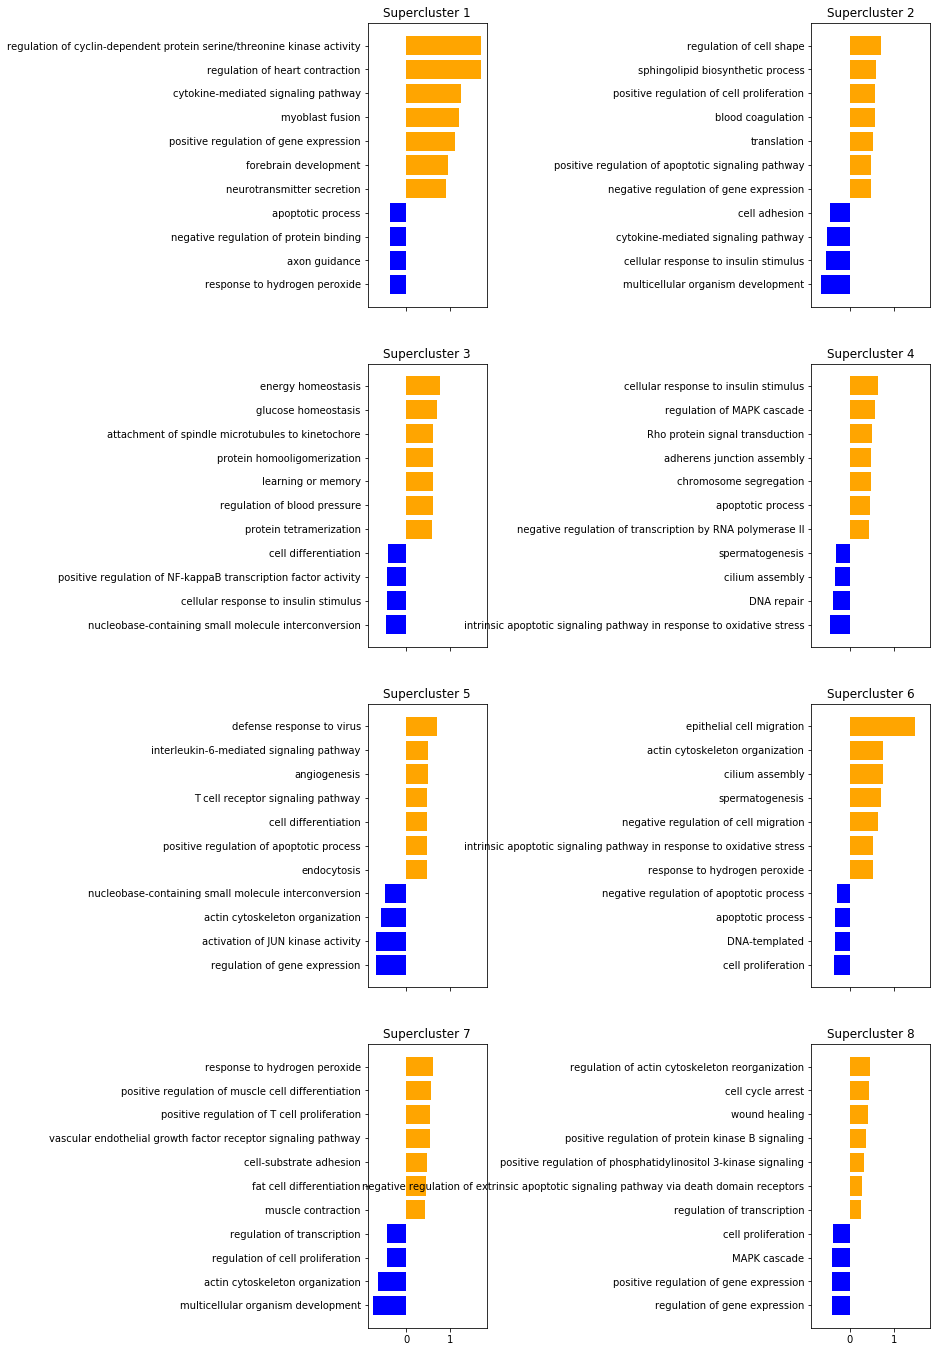

In [223]:
%matplotlib inline
fig, axes = plt.subplots(ncols=3, nrows=4, figsize= (16,24), sharex=True, gridspec_kw={'width_ratios':[1,20,20]})
plt.subplots_adjust(wspace=4.)
#plt.tight_layout()


for i in range(4):
    axes[i][0].axis('off')

for sup_ in super_sub_dict.keys():
    idx = sup_-1
    f_importances(coef=np.mean(get_svm_coeffs_for_cluster(louv_slim_super_characterizers[0], idx), axis=0), names=slim_feat, ax=axes[idx // 2][idx % 2+1], top=7, bot=4)
    axes[idx // 2][idx % 2+1].set_title('Supercluster '+str(sup_))

plt.savefig('super_char_PIR_PRO_slim.pdf')    
plt.show()
#plt.show()


### Cluster Comparison

In [116]:
spin = spinglass_clusters.set_index('names').drop('GO Labels', axis=1)
fast = pd.read_csv(cluster_dir+fastgreedy_file, sep='\t',index_col=0)

Below is the fast_greedy membership of each c_spinglass cluster

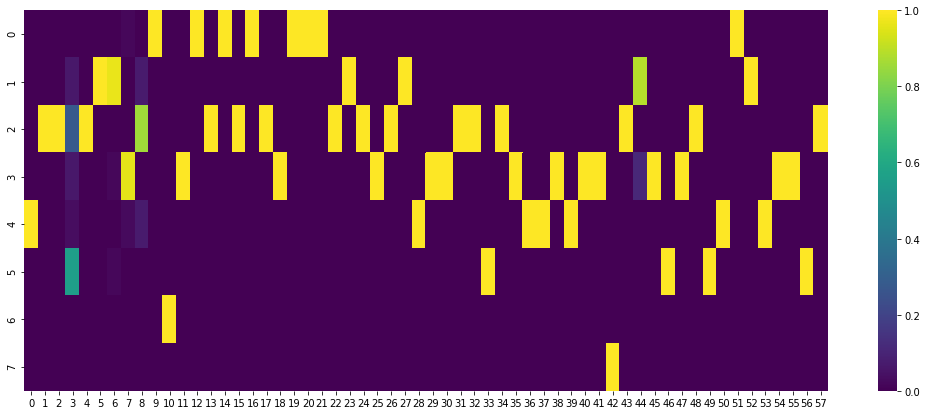

In [117]:
import seaborn as sns
from sklearn.metrics.cluster import contingency_matrix

cont_mat = pd.DataFrame(contingency_matrix(fast, spin))
#print(cont_mat.sum(axis=1))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=0),axis = 1)

fig, ax = plt.subplots(figsize=(18,7))

ann = np.copy(cont_mat)
sns.heatmap(cont_mat, ax=ax, cmap='viridis')

Below is the c_spinglass membership of each fast_greedy cluster

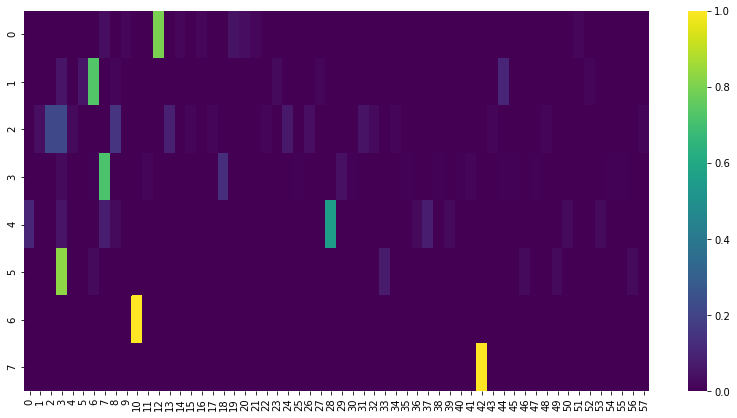

In [118]:
cont_mat = pd.DataFrame(contingency_matrix(fast, spin))
#print(cont_mat.sum(axis=1))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=1),axis = 0)

fig, ax = plt.subplots(figsize=(14,7))
sns.heatmap(cont_mat, ax=ax, cmap='viridis')

Rand correlation matrix

In [153]:
clusts = {}
for method in method_list:
    cl = composite_data_dict[method]['go']
    clusts[method] = np.squeeze(cl.drop(['GO Labels'], axis=1).values)

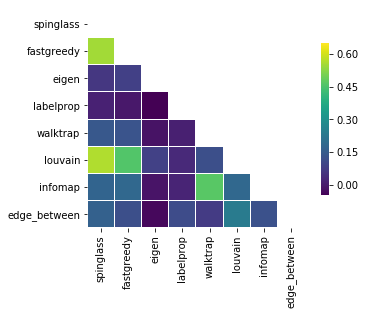

In [177]:
from sklearn.metrics import adjusted_rand_score as rand

rand_corr_matrix = np.zeros((len(clusts), len(clusts)))

for i in range(len(clusts)):
    for j in range(len(clusts)):
        rand_corr_matrix[i,j] = rand(clusts[method_list[i]], clusts[method_list[j]])

mask = np.zeros_like(rand_corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
        
sns.heatmap(rand_corr_matrix,mask=mask,cmap='viridis', square=True, vmax=0.65, cbar_kws={"shrink": .7}, linewidths=0.01, xticklabels=method_list,yticklabels=method_list)
plt.show()